In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png' 
import pylab as plb
import numpy as np
import scipy as sp
#import flylib as flb
#import group_data as gd
#import plotfuncs as plf
plb.rcParams['font.size'] =  9
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = False
import sys
sys.path.append('/media/analysis-code/figurefirst/')
import figurefirst as fifi

# Filter kernels

In [2]:
xi = np.linspace(-20,20,40000) #times
sf = 40000/40.0 #sampling frequency
step = ((xi>0) & (xi<3)).astype(float) #motion stimulus

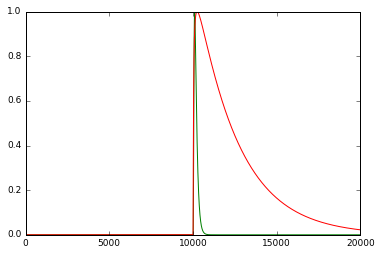

In [3]:
def make_kernel(tauon,tauoff):
    kx = np.linspace(0.1,20000,10000)
    kon = lambda x:np.exp(((-1*tauon)/(x)))
    koff = lambda x:np.exp((-1*x)/tauoff)
    k = (kon(kx)*koff(kx)/np.max(kon(kx)*koff(kx)))
    k = np.hstack((np.zeros_like(k),k)) #acausal
    return k

#fk = make_kernel(10,10) #fast kernel
sk = make_kernel(50,5000) #slow kernal (optimotor integrator)
mk = make_kernel(200.0,200.0) #muscle kernel -- calcium and GcAMP

plb.plot(mk,'g')
plb.plot(sk,'r')
#plb.plot(fk,'b')

# Sigmoid

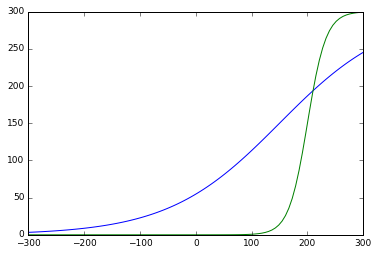

In [56]:
#muscle firing rate can range from 0 to 300 Hz
#sigmoid = lambda x: 300/(1+np.exp(-0.04*(x - 150))) #squashing function
sigmoid_t = lambda x: 300/(1+np.exp(-0.01*(x - 150))) #tonic squashing function
sigmoid_p = lambda x: 300/(1+np.exp(-0.06*(x - 200))) #phasic squashing function
inp = np.linspace(-300,300,100) #plot example sigmoid
plb.plot(inp,sigmoid_t(inp))
plb.plot(inp,sigmoid_p(inp))

In [137]:
from numpy import random
random.seed(2)

In [138]:
# the plot range
rng = ((xi>-3) & (xi<6))

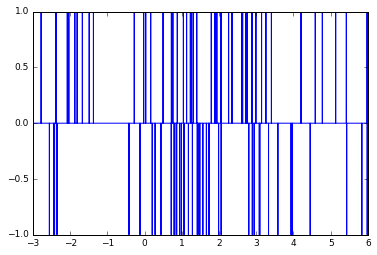

In [139]:
# create a common saccade trigger signal - sum
# of a positive and negative poisson process
BK_RATE = 3.0
MOTION_RATE = 5.0
n_common = np.random.poisson((step*MOTION_RATE+BK_RATE)/sf)
n_common -= np.random.poisson((step*MOTION_RATE+BK_RATE)/sf)
#n_common = np.random.poisson(np.ones_like(step)/sf*3)
#n_common -= np.random.poisson(np.ones_like(step)/sf*3)
plb.plot(xi[rng],n_common[rng])

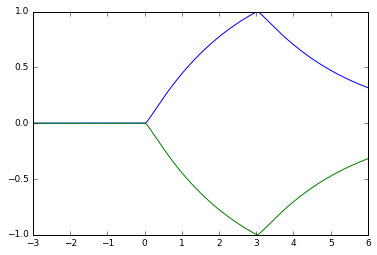

In [140]:
# create common integrated optomotor signal,
integrate = np.convolve(sk,step,mode = 'same')
integrate /= max(integrate)
plb.plot(xi[rng],integrate[rng])
plb.plot(xi[rng],-1*integrate[rng])

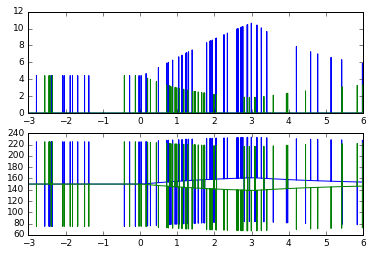

In [148]:
#the motor units recieve input from the tonic and phasic signals that differ
#in terms of the mean level of activity before being passed through
#the squashing sigmoid - in reality these should probably be passed through
#a synaptic kernel that is forced by mechanosensory input.

TONIC_BCK = 150
PHASIC_BCK = 20

#INT_GAIN = 6
#SAC_GAIN = 120

INT_GAIN = 15
SAC_GAIN = 110

rwing_phasic_ampup_in = sigmoid_p(integrate*INT_GAIN + n_common*SAC_GAIN + PHASIC_BCK)
rwing_phasic_ampdown_in = sigmoid_p(-1*integrate*INT_GAIN - n_common*SAC_GAIN + PHASIC_BCK)
lwing_phasic_ampup_in = sigmoid_p(-1*integrate*INT_GAIN - n_common*SAC_GAIN + PHASIC_BCK)
lwing_phasic_ampdown_in = sigmoid_p(integrate*INT_GAIN + n_common*SAC_GAIN + PHASIC_BCK)

rwing_tonic_ampup_in = sigmoid_t(integrate*INT_GAIN + n_common*SAC_GAIN + TONIC_BCK )
rwing_tonic_ampdown_in = sigmoid_t(-1*integrate*INT_GAIN - n_common*SAC_GAIN + TONIC_BCK )
lwing_tonic_ampup_in = sigmoid_t(-1*integrate*INT_GAIN - n_common*SAC_GAIN + TONIC_BCK )
lwing_tonic_ampdown_in = sigmoid_t(integrate*INT_GAIN + n_common*SAC_GAIN + TONIC_BCK )

plb.subplot(2,1,1)
plb.plot(xi[rng],rwing_phasic_ampup_in[rng])
plb.plot(xi[rng],rwing_phasic_ampdown_in[rng])
plb.subplot(2,1,2)
plb.plot(xi[rng],rwing_tonic_ampup_in[rng])
plb.plot(xi[rng],rwing_tonic_ampdown_in[rng])

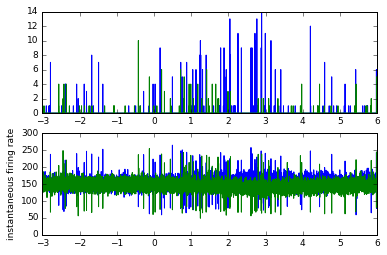

In [149]:
# to create the calcium signals we pass the muscle input rates through a poisson process to get 
# the 'muscle kernel'
rwing_phasic_ampup_f = np.random.poisson(rwing_phasic_ampup_in)
rwing_phasic_ampdown_f = np.random.poisson(rwing_phasic_ampdown_in)
lwing_phasic_ampup_f = np.random.poisson(lwing_phasic_ampup_in)
lwing_phasic_ampdown_f = np.random.poisson(lwing_phasic_ampdown_in)

rwing_tonic_ampup_f = np.random.poisson(rwing_tonic_ampup_in)
rwing_tonic_ampdown_f = np.random.poisson(rwing_tonic_ampdown_in)
lwing_tonic_ampup_f = np.random.poisson(lwing_tonic_ampup_in)
lwing_tonic_ampdown_f = np.random.poisson(lwing_tonic_ampdown_in)

plb.subplot(2,1,1)
plb.plot(xi[rng],rwing_phasic_ampup_f[rng])
plb.plot(xi[rng],rwing_phasic_ampdown_f[rng])
#plb.gca().set_xbound(0,0.2)
plb.subplot(2,1,2)
plb.plot(xi[rng],rwing_tonic_ampup_f[rng])
plb.plot(xi[rng],rwing_tonic_ampdown_f[rng])
plb.gca().set_ylabel('instantaneous firing rate')


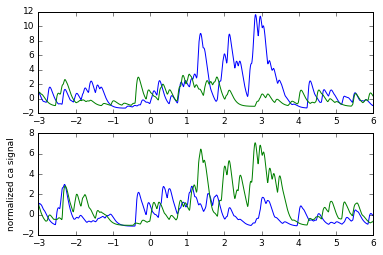

In [150]:
# to create the calcium signals we pass the muscle firing rates through the 'muscle kernel'
ca_sigs = dict()
ca_sigs[('right_wing','phasic','amp_up')] = np.convolve(mk,rwing_phasic_ampup_f,mode = 'same')
ca_sigs[('right_wing','phasic','amp_down')] = np.convolve(mk,rwing_phasic_ampdown_f,mode = 'same')
ca_sigs[('left_wing','phasic','amp_up')] = np.convolve(mk,lwing_phasic_ampup_f,mode = 'same')
ca_sigs[('left_wing','phasic','amp_down')] = np.convolve(mk,lwing_phasic_ampdown_f,mode = 'same')

ca_sigs[('right_wing','tonic','amp_up')] = np.convolve(mk,rwing_tonic_ampup_f,mode = 'same')
ca_sigs[('right_wing','tonic','amp_down')] = np.convolve(mk,rwing_tonic_ampdown_f,mode = 'same')
ca_sigs[('left_wing','tonic','amp_up')] = np.convolve(mk,lwing_tonic_ampup_f,mode = 'same')
ca_sigs[('left_wing','tonic','amp_down')] = np.convolve(mk,lwing_tonic_ampdown_f,mode = 'same')

for sig in ca_sigs.values():
    sig -= np.mean(sig[(xi<0)&(xi>-3)])
    sig /= np.std(sig[(xi<0)&(xi>-3)])
    
plb.subplot(2,1,1)

plb.plot(xi[rng],ca_sigs[('right_wing','phasic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('right_wing','phasic','amp_down')][rng])
#plb.twinx()
#plb.plot(xi[rng],rwing_phasic_ampup_f[rng])
plb.subplot(2,1,2)
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_down')][rng])
#plb.plot(xi[rng],ca_sigs[('right_wing','tonic','amp_up')][rng])
#plb.plot(xi[rng],ca_sigs[('right_wing','tonic','amp_down')][rng])
plb.gca().set_ylabel('normalized ca signal')

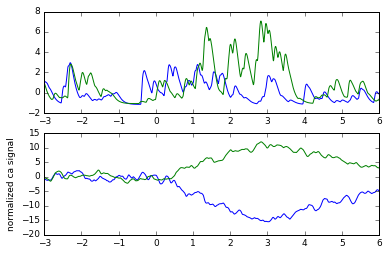

In [151]:
plb.subplot(2,1,1)
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('left_wing','phasic','amp_down')][rng])
plb.subplot(2,1,2)
plb.plot(xi[rng],ca_sigs[('left_wing','tonic','amp_up')][rng])
plb.plot(xi[rng],ca_sigs[('left_wing','tonic','amp_down')][rng])
plb.gca().set_ylabel('normalized ca signal')

In [152]:
rw = ca_sigs[('right_wing','tonic','amp_up')] + 1*ca_sigs[('right_wing','phasic','amp_up')] - \
            ca_sigs[('right_wing','tonic','amp_down')]-1*ca_sigs[('right_wing','phasic','amp_down')] 
    
lw = ca_sigs[('left_wing','tonic','amp_up')] + 1*ca_sigs[('left_wing','phasic','amp_up')] - \
        ca_sigs[('left_wing','tonic','amp_down')]-1*ca_sigs[('left_wing','phasic','amp_down')]
lmr = lw-rw

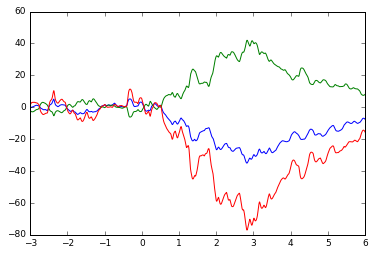

In [153]:
plb.plot(xi[rng],lw[rng])
plb.plot(xi[rng],rw[rng])
plb.plot(xi[rng],lw[rng]-rw[rng])

# Make plot

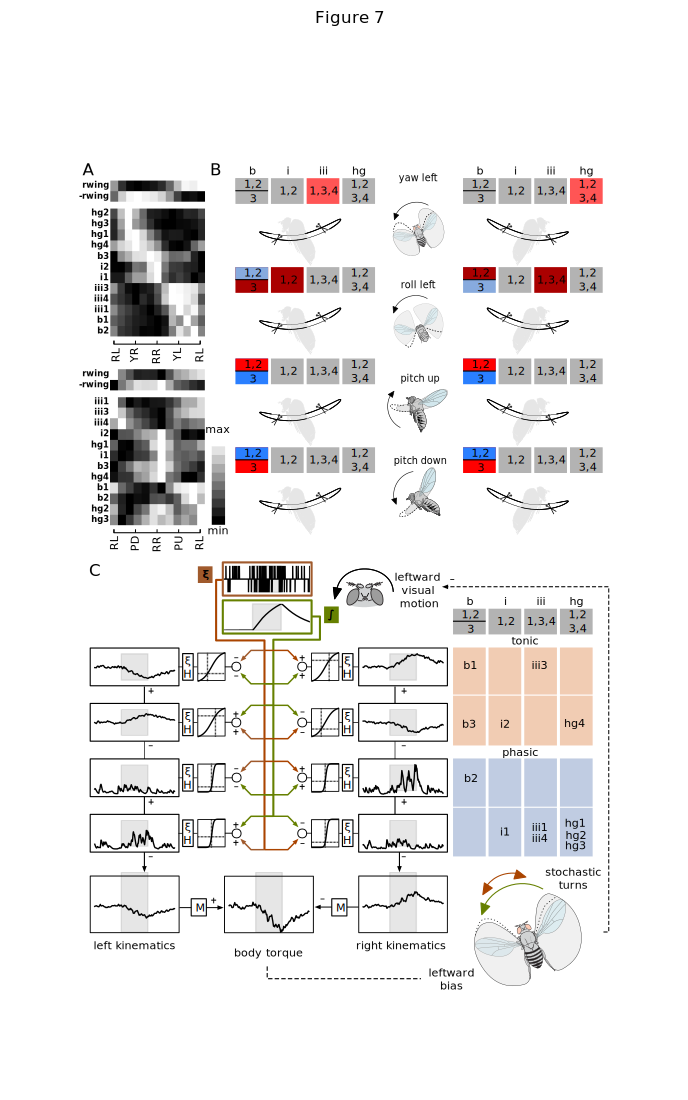

In [154]:
reload(fifi)
from matplotlib import colors
layout = fifi.FigureLayout('figure_7_layout.svg')
layout.make_mplfigures()

rng = ((xi>-3) & (xi<6))

tmax = np.max(np.hstack([ca_sigs[('left_wing','tonic','amp_up')][rng], 
                         ca_sigs[('left_wing','tonic','amp_down')][rng],
                         ca_sigs[('right_wing','tonic','amp_up')][rng],
                         ca_sigs[('right_wing','tonic','amp_down')][rng]]))

pmax = np.max(np.hstack([ca_sigs[('left_wing','phasic','amp_up')][rng], 
                         ca_sigs[('left_wing','phasic','amp_down')][rng],
                         ca_sigs[('right_wing','phasic','amp_up')][rng],
                         ca_sigs[('right_wing','phasic','amp_down')][rng]]))


for wing_key in ['left_wing','right_wing']:
    for dyn_key in ['tonic','phasic']:
        for amp_key in ['amp_up','amp_down']:
            ax = layout.axes[('model',wing_key,dyn_key,amp_key)]
            ax.plot(xi[rng],ca_sigs[(wing_key,dyn_key,amp_key)][rng],clip_on = False,color = 'k')
            if dyn_key == 'tonic':
                ax.set_ybound(-1*tmax,tmax)
            else:
                ax.set_ybound(0,pmax)

### wing_kine
mx = np.max(lmr[rng]);mn = np.min(lmr[rng])
rn = mx-mn;

ax = layout.axes_groups['none']['model']['YL']['left_wing']
ax.plot(xi[rng],lw[rng],clip_on = False,color = 'k')
ax.set_ybound(mn,mx+rn)

ax = layout.axes_groups['none']['model']['YL']['right_wing']
ax.plot(xi[rng],rw[rng],clip_on = False,color = 'k')
ax.set_ybound(mn,mx+rn)

ax = layout.axes_groups['none']['model']['YL']['lmr']
ax.plot(xi[rng],(lw-rw)[rng],clip_on = False,color = 'k')
ax.set_ybound(mn,mx+rn)

for key,ax in layout.axes.items():
    if (key[0] == 'model') & ~(key[1] =='squashing'):
        plb.sca(ax['axis'])
        ax.set_xbound(-3,6)
        #ax.set_ybound(-1,1)
        plb.axvspan(0,3,alpha = 0.1,color = 'k')
    fifi.mpl_functions.kill_spines(ax)
        #plf.kill_spines()
        
        
### sigmoids
for axkey,ax in layout.axes_groups['none']['model']['squashing']['left_squash'].items():
    if 't' in axkey:
        if 'up' in axkey:
            shift = -45
        if 'down' in axkey:
            shift = 45
        sigmoid = lambda x: 300/(1+np.exp(-0.02*(x - 150))) #squashing function
        inp = np.linspace(0,300,100) #plot example sigmoid
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')
    else:
        if 'up' in axkey:
            shift = -15
        if 'down' in axkey:
            shift = -5
        sigmoid = lambda x: 300/(1+np.exp(-0.1*(x - 150))) #squashing function
        inp = np.linspace(0+shift,300+shift,100)
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')

        
for axkey,ax in layout.axes_groups['none']['model']['squashing']['right_squash'].items():
    if 't' in axkey:
        if 'up' in axkey:
            shift = 45
        if 'down' in axkey:
            shift = -45
        sigmoid = lambda x: 300/(1+np.exp(-0.02*(x - 150))) #squashing function
        inp = np.linspace(0,300,100) #plot example sigmoid
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')
    else:
        if 'up' in axkey:
            shift = -5
        if 'down' in axkey:
            shift = -15
        sigmoid = lambda x: 300/(1+np.exp(-0.1*(x - 150))) #squashing function
        inp = np.linspace(0+shift,300+shift,100)
        ax.plot(inp,sigmoid(inp),color = 'k',clip_on = False)
        ax.axhline(sigmoid(150+shift),ls = (0,(0.5,0.5)),color = 'k')
        ax.axvline(150+shift,ls = (0,(0.5,0.5)),color = 'k')

layout.axes_groups['none']['model']['int_command'].plot(xi[rng],integrate[rng],color = 'k')
layout.axes_groups['none']['model']['sac_command'].plot(xi[rng],n_common[rng],color = 'k')

################################
################################
## Pannel B
################################
################################

import cPickle
with open('../08_roll_pitch_yaw/tc_summary_22H05.cpkl','rb') as f:
    tc_summary_22H05 = cPickle.load(f)
    
with open('../08_roll_pitch_yaw/tc_summary_39E01.cpkl','rb') as f:
    tc_summary_39E01 = cPickle.load(f)

for direction in tc_summary_22H05.values():
    for sig in direction.values():
        sig['mn'] -= np.min(sig['mn'])
        sig['mn'] /= np.max(sig['mn'])
        
for direction in tc_summary_39E01.values():
    for sig in direction.values():
        sig['mn'] -= np.min(sig['mn'])
        sig['mn'] /= np.max(sig['mn'])
        
## yaw roll
curve_list = list()
name_list = list()
peak_list = list()
beh_curves = list()

for name,grp in tc_summary_22H05['yaw_roll'].items():
    if not(name in ['Ph0','Ph1','wb_frequency','Ph2','lpr']):
        if name in ['b2','hg1','hg2','hg3','hg4']:
            rect = tc_summary_39E01['yaw_roll'][name]['mn']
            rect -= np.min(rect)
        else:
            rect = grp['mn']-np.min(grp['mn'])
        rect = np.hstack((rect,rect[0]))
        curve_list.append(rect/np.max(rect))
        peak_list.append(np.argmax(rect/np.max(rect)))
        name_list.append(name)
    elif name in ['Ph1']:
        rect = grp['mn']-np.min(grp['mn'])
        beh_curves.append(rect/np.max(rect))
        beh_curves.append(rect/np.max(rect)*-1 + 1)
        
sorted_curves = sorted(zip(curve_list,name_list,peak_list),key = lambda x:x[2])
ax = layout.axes_groups['none']['yaw_roll']['muscles']
ax.imshow([x[0] for x in sorted_curves],cmap = plb.cm.gray,aspect = 'auto')
ax.set_yticks(range(len(sorted_curves)))
lbs = ax.set_yticklabels([x[1] for x in sorted_curves])
ax.set_xticklabels([]);ax.set_xticks([])

ax = layout.axes_groups['none']['yaw_roll']['Ph1']
ax.imshow(beh_curves,cmap = plb.cm.gray,aspect = 'auto')
ax.set_yticks(range(2))
lbs = ax.set_yticklabels(['right wing','-right wing'])
ax.set_xticklabels([]);ax.set_xticks([])

## pitch roll
curve_list = list()
name_list = list()
peak_list = list()

beh_curves = list()
for name,grp in tc_summary_22H05['pitch_roll'].items():
    if not(name in ['Ph0','Ph1','wb_frequency','Ph2','lpr']):
        if name in ['b2','hg1','hg2','hg3','hg4']:
            rect = tc_summary_39E01['pitch_roll'][name]['mn']
            rect -= np.min(rect)
        else:
            rect = grp['mn']-np.min(grp['mn'])  
        rect = grp['mn']-np.min(grp['mn'])
        curve_list.append(rect/np.max(rect))
        peak_list.append(np.argmax(rect/np.max(rect)))
        name_list.append(name)
    elif name in ['Ph1']:
        rect = grp['mn']-np.min(grp['mn'])
        beh_curves.append(rect/np.max(rect))
        beh_curves.append(rect/np.max(rect)*-1 + 1)

sorted_curves = sorted(zip(curve_list,name_list,peak_list),key = lambda x:x[2])
ax = layout.axes_groups['none']['pitch_roll']['muscles']
ax.imshow([x[0] for x in sorted_curves],cmap = plb.cm.gray,aspect = 'auto')
ax.set_yticks(range(len(sorted_curves)))
lbs = ax.set_yticklabels([x[1] for x in sorted_curves])

ax = layout.axes_groups['none']['pitch_roll']['Ph1']
ax.imshow(beh_curves,cmap = plb.cm.gray,aspect = 'auto')
ax.set_xticklabels([]);ax.set_xticks([])

ax = layout.axes['cbar']
ax.imshow(np.array([np.linspace(0,1,10)[::-1]]).T,cmap = plb.cm.gray,aspect = 'auto')
ax.set_xticklabels([]);ax.set_xticks([])
ax.set_yticklabels([]);ax.set_yticks([])

for ax in layout.axes.values():
    ax.set_xticklabels([]);ax.set_xticks([])
    ax.set_yticklabels([]);ax.set_yticks([])
# load data from 
cardinal_idxs = {'c_yaw_left':(3,9),'c_yaw_right':(9,3),
'c_roll_left':(6,0),'c_roll_right':(0,6),
'c_pitch_up':(9,9),'c_pitch_down':(3,3)}

plb.close('all')
layout.insert_figures()
#layout.apply_svg_attrs()
layout.set_layer_visibility('Layer 1',False)
layout.write_svg('figure_7.svg')
from IPython.display import display,SVG
display(SVG('figure_7.svg'))

In [127]:
for direction in tc_summary_22H05.values():
    for sig in direction.values():
        sig['mn'] -= np.min(sig['mn'])
        sig['mn'] /= np.max(sig['mn'])

In [ ]:
# load data from 
cardinal_idxs = {'c_yaw_left':(3,9),'c_yaw_right':(9,3),
'c_roll_left':(6,0),'c_roll_right':(0,6),
'c_pitch_up':(3,9),'c_pitch_down':(9,3)}

direction_dict = dict()
for direction in ['c_yaw_left','c_yaw_right',
                  'c_roll_left','c_roll_right',
                  'c_pitch_up','c_pitch_down',]:
    signal_dict = dict()
    for signal in ['b1','b2','b3',
                       'i1','i2',
                       'iii1','iii3','iii24',
                       'hg1','hg2','hg3','hg4']:
        wing_dict = dict()
        for wing in ['lw','rw']:
            if wing == 'lw':
                idx = cardinal_idxs[direction][0]
                if 'yaw' in direction:
                    wing_dict[wing] = tc_summary_22H05['yaw_roll'][signal]['mn'][idx]
                if 'pitch' in direction:
                    wing_dict[wing] = tc_summary_22H05['yaw_roll'][signal]['mn'][idx]
                if 'roll' in direction:
                    wing_dict[wing] = tc_summary_22H05['pitch_roll'][signal]['mn'][idx]
            if wing == 'rw':
                idx = cardinal_idxs[direction][1]
                if 'yaw' in direction:
                    wing_dict[wing] = tc_summary_22H05['yaw_roll'][signal]['mn'][idx]
                if 'pitch' in direction:
                    wing_dict[wing] = tc_summary_22H05['yaw_roll'][signal]['mn'][idx]
                if 'roll' in direction:
                    wing_dict[wing] = tc_summary_22H05['pitch_roll'][signal]['mn'][idx]
        signal_dict[signal] = wing_dict
    direction_dict[direction] = signal_dict

In [ ]:
tc_summary_22H05['yaw_roll']['hg2']['mn'][9]

In [ ]:
plb.plot(tc_summary_39E01['yaw_roll']['hg2']['mn'])